In [33]:
import string

import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.basemap import Basemap
from numpy import *
from matplotlib.pyplot import *

## Parameters

In [34]:
#Notebook parameters

#If you set this to True, to use the full dataset, you need to download it here
#https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/csv/
#And put the file `ibtracs.since1980.list.v04r00.csv` inside the data folder
loadFromFullData = False

#zoneAnalysis = "Japan"
zoneAnalysis = "Gulf of Mexico"

In [35]:
#usefull global variables
maxLon, minLon, maxLat, minLat = 0,0,0,0
minYear = 1998
maxYear = 2015

if (zoneAnalysis == "Gulf of Mexico"):
    maxLon = 280
    minLon = 258
    maxLat = 30
    minLat = 18
else:
    maxLon = 145
    minLon = 120
    maxLat = 40
    minLat = 20

windSpeedBins = [-10, 0, 34, 64, 83, 96, 113, 137, 300]
categoryLabels = ["Unknown", "TD", "TS", "1", "2", "3", "4", "5"]

## Plot methods

In [36]:
# function to plot images
def plot_im(lon,lat,im,size_points,var_name):

    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)

    if max(lon)-min(lon)<100:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='robin',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)

    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    #im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)

# function to plot time series
def plot_ts(time,ts,line_type,var_name):

    # plot
    plot_date(time,ts,line_type)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)

# IBTRACS Dataset loading

## Data loading

In [37]:
if (loadFromFullData):
    data = pd.read_csv("data/ibtracs.since1980.list.v04r00.csv")
    data.drop(index=[0], inplace=True)

C:\Users\guyll\AppData\Local\Temp\ipykernel_6360\1620283388.py:2: DtypeWarning: Columns (1,2,8,9,14,161,162) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data/ibtracs.since1980.list.v04r00.csv")


## Preprocessing

In [38]:
if (loadFromFullData):
    #time conversion
    data.SEASON = data.SEASON.astype("int32")
    data.ISO_TIME = pd.to_datetime(data.ISO_TIME)
    data["NSEC_TIME"] = data.ISO_TIME.astype("int64")

    #coord conversion
    data.LAT = data.LAT.astype("float32")
    data.LAT = data.LAT.round(3)
    data.LON = data.LON.astype("float32")
    data.LON = data.LON.round(3)
    data.loc[data.LON < 0, 'LON'] = data[data.LON < 0].LON + 360

    #category creation
    #using wind speed from USA_WIND (instead of WMO_WIND) since there are less unknown data
    #print(data.USA_WIND.describe())
    #print(data.WMO_WIND.describe())
    data.loc[data.USA_WIND == ' ', "USA_WIND"] = "-1"
    data['USA_WIND'] = data['USA_WIND'].astype("float32")
    data["CATEGORY"] = pd.cut(data['USA_WIND'], bins=windSpeedBins, labels=categoryLabels)

    dataTime = data[(data.SEASON >= minYear) & (data.SEASON <= maxYear)]
    dataSpace = dataTime[(dataTime.LON > minLon) & (dataTime.LON < maxLon) & (dataTime.LAT > minLat) & (dataTime.LAT < maxLat)]

    dataSpace = dataSpace.drop(index=dataSpace.loc[dataSpace.CATEGORY == "Unknown"].index)

    dataSpace.head()

## Direct loading from zone files

In [39]:
if not loadFromFullData:
    #data loading from zone files
    cyclonesMapData: pd.DataFrame
    if (zoneAnalysis == "Japan"):
        cyclonesMapData = pd.read_csv("data/ibtracs-japan-1998-2015.csv")
    else:
        cyclonesMapData = pd.read_csv("data/ibtracs-gulf of mexico-1998-2015.csv")

    #time conversion
    cyclonesMapData.ISO_TIME = pd.to_datetime(cyclonesMapData.ISO_TIME)
    cyclonesMapData["NSEC_TIME"] = cyclonesMapData.NSEC_TIME.astype("int64")

## Unique cyclones extraction

In [40]:
if loadFromFullData:
    #data extraction from previous preprocessing
    cyclonesMapData = dataSpace[["LAT", "LON", "SID", "USA_WIND", "NSEC_TIME"]].groupby(["SID"], as_index=False).agg(LAT = ("LAT", "mean"), LON = ("LON", 'mean'), NSEC_TIME = ("NSEC_TIME", 'mean'), USA_WIND = ("USA_WIND", 'max'))
else:
    cyclonesMapData = cyclonesMapData.groupby(["SID"], as_index=False).agg(LAT = ("LAT", "mean"), LON = ("LON", 'mean'), NSEC_TIME = ("NSEC_TIME", 'mean'), USA_WIND = ("USA_WIND", 'max'))

cyclonesMapData["NSEC_TIME"] = pd.to_datetime(cyclonesMapData["NSEC_TIME"], unit='ns')

In [41]:
cyclonesMapData

,SID,LAT,LON,NSEC_TIME,USA_WIND
0,1998233N25268,27.659124,262.670776,1998-08-22 14:47:30.000000000,60.0
1,1998244N22267,25.901272,268.747406,1998-09-01 19:30:00.000000000,85.0
2,1998252N26266,26.206821,264.323547,1998-09-10 10:30:00.000000000,55.0
3,1998259N10335,26.423000,274.761353,1998-09-26 16:58:50.769230720,95.0
4,1998261N27270,27.140280,268.436707,1998-09-18 23:43:12.000000000,40.0
...,...,...,...,...,...
103,2013255N19268,21.310905,264.381653,2013-09-14 18:58:55.714285568,75.0
104,2013276N21273,25.434641,270.003845,2013-10-04 18:00:00.000000000,55.0
105,2014245N19268,21.623827,263.512451,2014-09-02 18:44:20.869565184,45.0
106,2014294N20265,18.975945,269.575409,2014-10-23 06:30:00.000000000,30.0


# Map image plotting

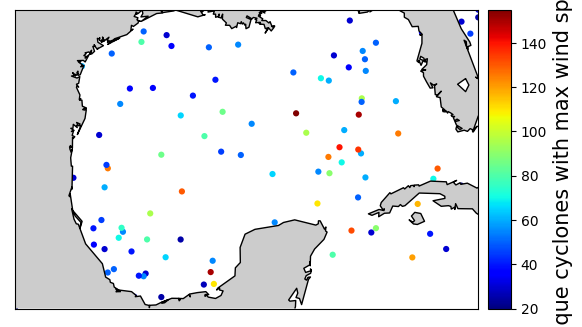

In [42]:
plot_im(cyclonesMapData.LON, cyclonesMapData.LAT, cyclonesMapData.USA_WIND, 20, "Unique cyclones with max wind speed")

# Descriptive analysis plotting

In [43]:
# Adding more columns about time and cyclone category (from average wind speed)
cyclonesMapData["MONTH_TIME"] = cyclonesMapData["NSEC_TIME"].dt.month
cyclonesMapData["YEAR_TIME"] = cyclonesMapData["NSEC_TIME"].dt.year
cyclonesMapData["CATEGORY"] = pd.cut(cyclonesMapData['USA_WIND'], bins=windSpeedBins, labels=categoryLabels)
cyclonesMapData[cyclonesMapData["YEAR_TIME"] == 2010]

,SID,LAT,LON,NSEC_TIME,USA_WIND,MONTH_TIME,YEAR_TIME,CATEGORY
78,2010176N16278,21.888256,265.620758,2010-06-29 17:21:32.307692288,95.0,6,2010,2
79,2010188N21269,24.997000,263.414032,2010-07-08 13:31:18.260869632,30.0,7,2010,TD
80,2010203N22286,27.616055,274.198212,2010-07-24 13:38:20.000000000,35.0,7,2010,TS
81,2010222N26277,28.072552,273.557434,2010-08-12 19:33:06.206896640,30.0,8,2010,TD
82,2010247N15266,22.931084,263.648712,2010-09-06 09:42:30.000000000,60.0,9,2010,TS
83,2010257N16282,19.034548,268.370911,2010-09-16 12:10:38.709677568,110.0,9,2010,3
84,2010271N19276,21.068867,277.713806,2010-09-28 21:00:00.000000000,40.0,9,2010,TS
85,2010284N14278,21.295416,275.372681,2010-10-13 22:30:00.000000000,90.0,10,2010,2
86,2010293N17277,19.008833,267.936676,2010-10-26 04:30:00.000000000,27.0,10,2010,TD


<AxesSubplot: title={'center': 'Cyclones count by year and category in Gulf of Mexico'}>

<Figure size 2000x700 with 0 Axes>

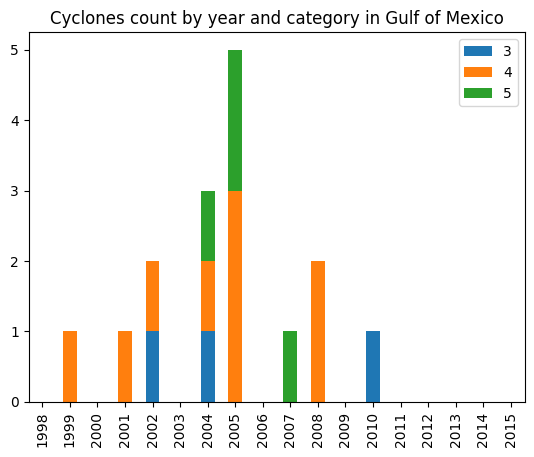

In [44]:
# Display cyclones by category for each year
typhoonCountByYear = pd.DataFrame(index=cyclonesMapData["YEAR_TIME"].unique())
for category in categoryLabels[1:]:
    typhoonCountByYear[category] = cyclonesMapData[["YEAR_TIME", "CATEGORY"]][cyclonesMapData["CATEGORY"] == category].groupby("YEAR_TIME").count()["CATEGORY"]
figure(figsize=(20, 7))
typhoonCountByYear[["3", "4", "5"]].plot.bar(stacked=True, title='Cyclones count by year and category in ' + zoneAnalysis)

In [45]:
typhoonCountByYear

,TD,TS,1,2,3,4,5
1998,NaN,4,NaN,2.0,NaN,NaN,NaN
1999,4.0,1,1.0,NaN,NaN,1.0,NaN
2000,3.0,2,2.0,NaN,NaN,NaN,NaN
2001,NaN,4,NaN,NaN,NaN,1.0,NaN
2002,2.0,4,NaN,NaN,1.0,1.0,NaN
2003,1.0,4,2.0,NaN,NaN,NaN,NaN
2004,NaN,2,NaN,1.0,1.0,1.0,1.0
2005,NaN,5,2.0,NaN,NaN,3.0,2.0
2006,1.0,2,NaN,NaN,NaN,NaN,NaN
2007,2.0,2,2.0,NaN,NaN,NaN,1.0


<AxesSubplot: title={'center': 'Cyclones count by month and category in Gulf of Mexico'}>

<Figure size 2000x700 with 0 Axes>

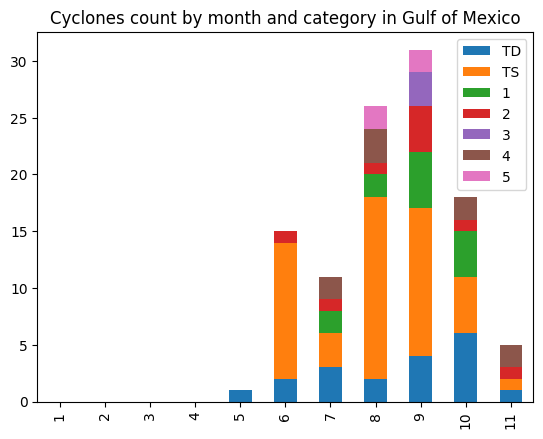

In [46]:
# Display cyclones by category for each month
typhoonCountByMonth = pd.DataFrame(index = [i for i in range(1,12)])

for category in categoryLabels[1:]:
     typhoonCountByMonth[category] = cyclonesMapData[["MONTH_TIME", "CATEGORY"]][cyclonesMapData["CATEGORY"] == category].groupby("MONTH_TIME").count()["CATEGORY"]
figure(figsize=(20, 7))

typhoonCountByMonth.plot.bar(stacked=True, title='Cyclones count by month and category in ' + zoneAnalysis)

<AxesSubplot: title={'center': 'Average cyclones count by month in Gulf of Mexico'}>

<Figure size 2000x700 with 0 Axes>

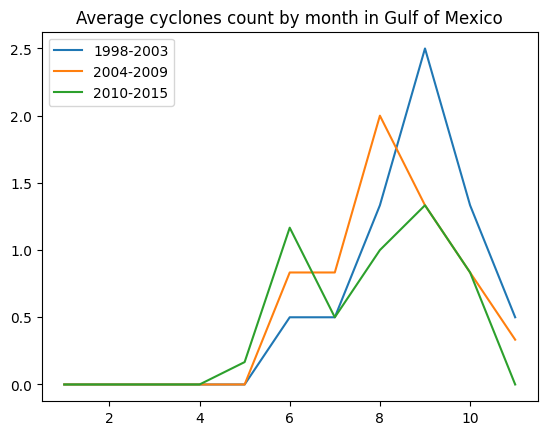

In [47]:
# Display average cyclone count by month for selected years bins

binSize = 6 #years count for each bin
#get months in order in dataset
typhoonCountByMonth = pd.DataFrame(index = [i for i in range(1,12)])

#get bins for years
yearList = cyclonesMapData.YEAR_TIME.unique()
yearList = [yearList[i] if i<len(yearList) else 2016 for i in range(0, len(yearList)+binSize, binSize)]

#extract data for months and years
for i in range(len(yearList)-1):
     typhoonCountByMonth[str(yearList[i])+"-"+str(yearList[i+1]-1)] = cyclonesMapData[["MONTH_TIME", "YEAR_TIME"]][(cyclonesMapData["YEAR_TIME"] >= yearList[i]) & (cyclonesMapData["YEAR_TIME"] < yearList[i+1])].groupby("MONTH_TIME").count()["YEAR_TIME"]/binSize
figure(figsize=(20, 7))

#sort by months and add 0 for missing data
typhoonCountByMonth.fillna(0, inplace=True)

#plot
typhoonCountByMonth.plot(title='Average cyclones count by month in ' + zoneAnalysis)

# Dataset saving

In [48]:
if (loadFromFullData):
    usefullData = dataSpace[["LAT", "LON", "SID", "USA_WIND", "CATEGORY", "NSEC_TIME", "ISO_TIME"]]
    usefullData

In [49]:
if (loadFromFullData):
    usefullData.to_csv("data/ibtracs-"+zoneAnalysis.lower()+"-1998-2015.csv", index_label=False)